In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

%matplotlib inline

# Data augmentation

Let's import data and see how many labels are there

In [5]:
train_dir = Path('../input/journey-springfield/train/simpsons_dataset')
test_dir = Path('../input/journey-springfield/testset/testset')

train_files = sorted(list(train_dir.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]
test_files = sorted(list(test_dir.rglob('*.jpg')))

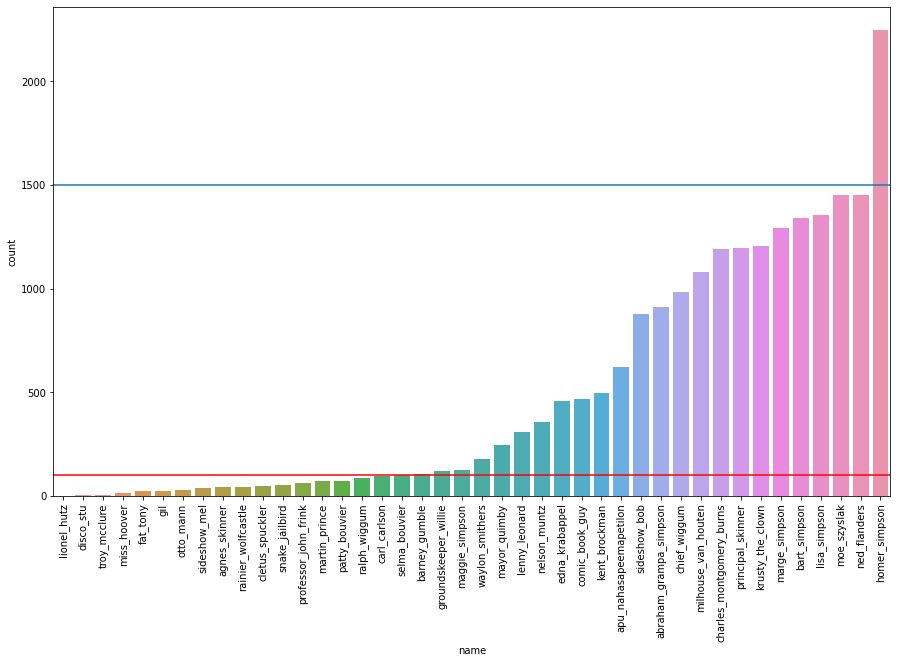

In [6]:
import seaborn as sns

def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1500)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

data = get_count(train_labels)
show_data(data)

Some classes have very few samples in dataset, therefore augmentation is required. Visualisation as well as augmentation are borrowed from [here](https://www.kaggle.com/code/marinalakeeva/data-augmentation)

In [7]:
RESCALE_SIZE = 224

augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)

In [8]:
BATCH_SIZE = 256

class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

  0%|          | 0/20933 [00:00<?, ?it/s]

In [9]:
N_CORES = 2

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

In [10]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

  0%|          | 0/369 [00:00<?, ?it/s]

94332 Counter({25: 2336, 8: 2302, 15: 2300, 19: 2300, 39: 2295, 14: 2294, 21: 2294, 37: 2293, 29: 2287, 7: 2284, 31: 2278, 9: 2276, 6: 2271, 40: 2267, 28: 2262, 1: 2259, 4: 2258, 2: 2257, 23: 2254, 12: 2252, 32: 2252, 27: 2252, 3: 2247, 16: 2246, 10: 2243, 18: 2240, 30: 2239, 24: 2239, 11: 2238, 41: 2236, 0: 2230, 22: 2230, 17: 2220, 36: 2219, 5: 2217, 26: 2210, 20: 2205, 13: 2204, 33: 2197, 38: 2129, 34: 2126, 35: 2094})


# Simple model

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def train(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [13]:
DEVICE = torch.device("cpu")

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")

n_classes = len(np.unique(train_labels))
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Linear(in_features=2400, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=n_classes, bias=True)
).to(DEVICE)

In [15]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
history = train(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.5292 train_acc 0.8496

Epoch 002 train_loss: 0.2579 train_acc 0.9247

Epoch 003 train_loss: 0.1708 train_acc 0.9483

Epoch 004 train_loss: 0.1236 train_acc 0.9640

Epoch 005 train_loss: 0.1004 train_acc 0.9695

Epoch 006 train_loss: 0.0800 train_acc 0.9761

Epoch 007 train_loss: 0.0659 train_acc 0.9798

Epoch 008 train_loss: 0.0301 train_acc 0.9911

Epoch 009 train_loss: 0.0207 train_acc 0.9940

Epoch 010 train_loss: 0.0158 train_acc 0.9955

Epoch 011 train_loss: 0.0141 train_acc 0.9960

Epoch 012 train_loss: 0.0115 train_acc 0.9967

Epoch 013 train_loss: 0.0105 train_acc 0.9969

Epoch 014 train_loss: 0.0097 train_acc 0.9973

Epoch 015 train_loss: 0.0084 train_acc 0.9976

Epoch 016 train_loss: 0.0079 train_acc 0.9978

Epoch 017 train_loss: 0.0084 train_acc 0.9977

Epoch 018 train_loss: 0.0079 train_acc 0.9978

Epoch 019 train_loss: 0.0079 train_acc 0.9980

Epoch 020 train_loss: 0.0079 train_acc 0.9978


In [22]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv('Simpsons_classifier.csv', index=False)

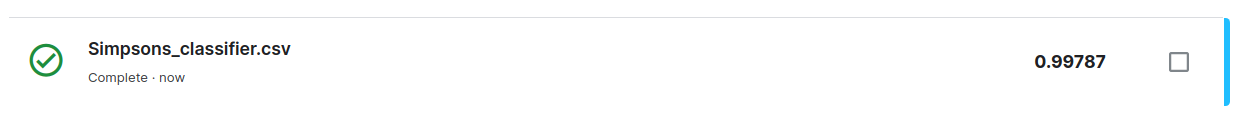